In [1]:
# this command is executed twice for interactive plotting in Jupyter notebook
%matplotlib notebook
%matplotlib notebook

In [3]:
NEW_EXPERIMENTS = False
NEW_AVERAGING = True
NEW_METRICS = True

In [4]:
# standard modules
from pathlib import Path, PosixPath
import pickle as pkl
import pandas as pd
from tqdm.notebook import tqdm
import xarray
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# custom imports
from model.camels_utilities import load_usgs, load_forcings
from codebase.evaluation.metrics import get_available_metrics, calculate_all_metrics

In [6]:
# test dates
test_start_date = '10/01/1989'
test_end_date = '09/30/1999'
test_dates = pd.date_range(test_start_date,test_end_date)

# train dates
train_start_date = '01/10/1999'
train_end_date = '09/30/2008'
train_dates = pd.date_range(train_start_date, train_end_date)

In [7]:
# experiment metadata
results_dir = Path('/home/gsnearing/projects/multi-inputs/SACSMA-SNOW17/results')
forcing_types = ['daymet', 'maurer','nldas']
config_nums = list(range(1,11))

In [8]:
# get list of basins from actual results (not a basin file)
dummy_run_dir = results_dir / 'daymet/config_1'
basin_files = list(Path(dummy_run_dir).glob('*.pkl'))
basins = []
for bfile in basin_files:
    basins.append(str(bfile).split('/')[-1].split('.')[0])
num_basins = len(basins)

In [9]:
# load discharge data
if NEW_EXPERIMENTS:
    
    camels_dir = Path('/home/gsnearing/projects/camels_data/basin_dataset_public_v1p2')
    usgs = pd.DataFrame(columns=basins)
    for basin in tqdm(basins):
        _, area = load_forcings(basin,'nldas')
        df = load_usgs(basin, area)
        usgs[basin] = df['QObs']

    with open('notebook_env_saves/usgs_runoff_data.pkl', 'wb') as f:
        pkl.dump(usgs, f)

else:
    with open('notebook_env_saves/usgs_runoff_data.pkl', 'rb') as f:
        usgs = pkl.load(f)     

In [10]:
# load calibrated sacsma runs
if NEW_EXPERIMENTS:

    # init storage
    print('Initializing dataframe for storing all sacsma runs')
    all_sacsma_restarts = {}
    experiment_multiindex = pd.MultiIndex.from_product([forcing_types, config_nums])
    for basin in tqdm(basins):
        all_sacsma_restarts[basin] = pd.DataFrame(columns=experiment_multiindex)
    
    print('Loading all sacsma runs')
    for ftype in forcing_types:
        print(ftype)
        for cnum in tqdm(config_nums):
            run_dir = results_dir / ftype / f'config_{cnum}'
            basin_files = list(run_dir.glob('*.pkl')) 
            assert len(basin_files) == num_basins
            for basin in basins:
                basin_file = run_dir / f'{basin}.pkl'
                with open (basin_file, 'rb') as f:
                    data = pkl.load(f)
                all_sacsma_restarts[basin][(ftype,cnum)] = data[1]
                
    print('Calcualting ensemble means')
    sacsma = {}
    for basin in tqdm(basins):
        sacsma[basin] = pd.DataFrame(index=all_sacsma_restarts[basin][(ftype,cnum)].index, columns=forcing_types)
        for ftype in forcing_types:
            sacsma[basin][ftype] = all_sacsma_restarts[basin][ftype].mean(axis=1)
        
    print('Saving ensemble means')
    with open('notebook_env_saves/sacsma_mean_hydrographs.pkl', 'wb') as f:
        pkl.dump(sacsma, f)

else:
    with open('notebook_env_saves/sacsma_mean_hydrographs.pkl', 'rb') as f:
        sacsma = pkl.load(f)     

<IPython.core.display.Javascript object>


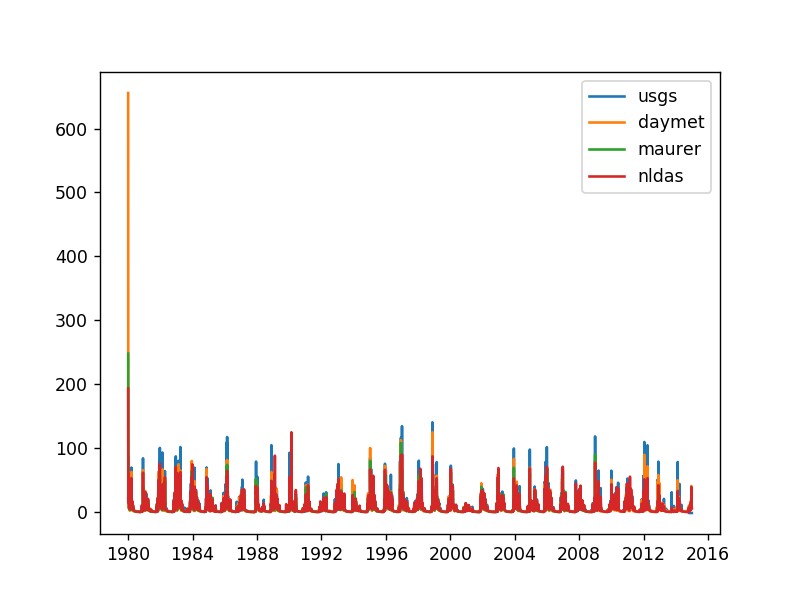

In [12]:
plt.plot(usgs[basins[-1]], label='usgs')
for ftype in forcing_types:
    plt.plot(sacsma[basins[-1]][ftype], label=ftype)
plt.legend()

In [76]:
def model_averaging(ensemble_df, observation_df, train_dates):
    
    # extract models that we will average over
    models = list(ensemble_df.columns)
    
    # estimate weights based on training-period fits
    diff = ensemble_df.loc[train_dates].sub(observation_df.loc[train_dates], axis=0)
#     weights = np.sqrt((diff**2).mean())

    sigma = 50
    N = diff.shape[0]
    constant_term = -N/2*np.log(2*np.pi*sigma**2)
    scaler_term = -1/(2*sigma**2)
    log_term = (diff**2).sum()
    log_like = constant_term + scaler_term*log_term
    probability = pd.Series(index=models)  
    for model in models:
        probability[model] = 0
        for mod in models:
            probability[model] = probability[model] + np.exp(log_like[mod]-log_like[model])
        probability[model] = 1/probability[model]
    weights = probability / np.sum(probability)
    
#     weights = ((diff**2).mean())
#     weights['nldas'] = 1
#     weights['daymet'] = 1
#     weights['maurer'] = 1
#     weights = weights / np.sum(weights)

    # weight test period into a single hydrograph
    hydrograph = ensemble_df.dot(weights)
        
    return hydrograph, weights

In [77]:
# run mixing strategy
if NEW_AVERAGING:

    sacsma_mixture_hydrograph = pd.DataFrame(columns=basins)
    mixture_weights = pd.DataFrame(columns=basins)
    for basin in tqdm(basins):
        sacsma_mixture_hydrograph[basin], mixture_weights[basin] = model_averaging(sacsma[basin], 
                                                                                   usgs[basin], 
                                                                                   train_dates)
    print('Saving model averages means')
    with open('notebook_env_saves/sacsma_model_averages.pkl', 'wb') as f:
        pkl.dump(sacsma_mixture_hydrograph, f)

else:
    with open('notebook_env_saves/sacsma_model_averages.pkl', 'rb') as f:
        sacsma_mixture_hydrograph = pkl.load(f)         

/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()



Saving model averages means


In [78]:
mixture_weights

,01466500,01440400,01022500,01414500,01073000,01451800,01195100,01139000,01139800,01350000,...,11475560,11476600,11478500,11480390,11481200,11482500,11522500,11523200,11528700,11532500
daymet,0.295154,0.276579,0.354360,0.258101,0.318456,0.385331,0.245202,0.343637,0.281290,0.215990,...,0.059480,0.006637,0.077060,0.143088,0.317733,0.209768,0.246869,0.412849,0.336231,0.469276
maurer,0.385084,0.198272,0.307506,0.224287,0.306732,0.281812,0.338195,0.332933,0.372127,0.179305,...,0.072937,0.157929,0.022231,0.233612,0.188795,0.205596,0.325899,0.190219,0.300228,0.123860
nldas,0.319762,0.525149,0.338134,0.517612,0.374812,0.332857,0.416603,0.323430,0.346583,0.604705,...,0.867583,0.835434,0.900710,0.623300,0.493471,0.584636,0.427232,0.396932,0.363541,0.406864


In [79]:
# store ensemble means as xarray data sets
if NEW_METRICS:
    
    xr_dict = {}
    for basin in basins:
        xr_data = {}
        xr_data['qsim'] = (('date'), sacsma_mixture_hydrograph.loc[test_dates, basin])
        xr_data['qobs'] = (('date'), usgs.loc[test_dates, basin])
        xr_dict[basin] = xarray.Dataset(data_vars=xr_data,
                                            coords={
                                              'date': test_dates,
                                              'time_step': np.arange(0, 1)
                                            })

    with open('notebook_env_saves/xarray_averaged_sacsma.pkl', 'wb') as f:
        pkl.dump(xr_dict, f)

else:
    with open('notebook_env_saves/xarray_averaged_sacsma.pkl', 'rb') as f:
        xr_dict = pkl.load(f)    

In [80]:
# calculate metrics
if NEW_METRICS:
    
    metric_names = get_available_metrics()
    metrics = pd.DataFrame(index=basins, columns=metric_names)

    # calculating metrics
    for basin in tqdm(basins):
        sim = xr_dict[basin]['qsim']
        obs = xr_dict[basin]['qobs']
        sim_metrics = calculate_all_metrics(obs, sim)

        for metric in metric_names:
            metrics.loc[basin, metric] = sim_metrics[metric]   
    
    with open('notebook_env_saves/metrics.pkl', 'wb') as f:
        pkl.dump(metrics, f)
else:
    with open('notebook_env_saves/metrics.pkl', 'rb') as f:
        metrics = pkl.load(f)    

In [81]:
metrics.median()

NSE             0.705493
MSE             1.790353
RMSE            1.338041
KGE             0.653530
Alpha-NSE       0.746579
Pearson r       0.861060
Beta-NSE        0.020393
FHV           -23.398839
FMS           -28.731902
FLV            49.622074
Peak-Timing     0.555556
dtype: float64

In [82]:
metrics.mean()

NSE            6.662704e-01
MSE            3.447651e+00
RMSE           1.553469e+00
KGE            6.224072e-01
Alpha-NSE      7.392277e-01
Pearson r      8.421442e-01
Beta-NSE       2.224565e-02
FHV           -2.339723e+01
FMS            3.494485e+05
FLV           -1.551258e+09
Peak-Timing    8.072990e-01
dtype: float64

In [17]:
# store ensemble means as xarray data sets
if NEW_METRICS:
    
    xr_dict_individuals = {}
    for ftype in forcing_types:
        for basin in basins:
            xr_data = {}
            xr_data['qsim'] = (('date'), sacsma[basin].loc[test_dates, ftype])
            xr_data['qobs'] = (('date'), usgs.loc[test_dates, basin])
            xr_dict_individuals[(ftype,basin)] = xarray.Dataset(data_vars=xr_data,
                                                                coords={
                                                                  'date': test_dates,
                                                                  'time_step': np.arange(0, 1)
                                                                })

    with open('notebook_env_saves/xarray_individual_sacsma.pkl', 'wb') as f:
        pkl.dump(xr_dict_individuals, f)

else:
    with open('notebook_env_saves/xarray_individual_sacsma.pkl', 'rb') as f:
        xr_dict_individuals = pkl.load(f)    

In [18]:
# calculate metrics
if NEW_METRICS:
    
    metric_names = get_available_metrics()
    multiindex = pd.MultiIndex.from_product([forcing_types, metric_names])
    metrics_individuals = pd.DataFrame(index=basins, columns=multiindex)

    # calculating metrics
    for ftype in forcing_types:
        print(ftype)
        for basin in tqdm(basins):
            sim = xr_dict_individuals[(ftype,basin)]['qsim']
            obs = xr_dict_individuals[(ftype,basin)]['qobs']
            sim_metrics = calculate_all_metrics(obs, sim)

            for metric in metric_names:
                metrics_individuals.loc[basin, (ftype,metric)] = sim_metrics[metric]   
    
    with open('notebook_env_saves/metrics_individuals.pkl', 'wb') as f:
        pkl.dump(metrics, f)
else:
    with open('notebook_env_saves/metrics_individuals.pkl', 'rb') as f:
        metrics_individuals = pkl.load(f)    

daymet


/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/gsnearing/anaconda3/envs/pytorch-cuda9/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/hom


maurer



nldas


In [19]:
metrics_individuals.median()

daymet  NSE             0.645478
        MSE             2.158144
        RMSE            1.469062
        KGE             0.596481
        Alpha-NSE       0.757142
        Pearson r       0.831074
        Beta-NSE        0.065738
        FHV           -21.286292
        FMS           -39.555899
        FLV            52.650704
        Peak-Timing     0.586207
maurer  NSE             0.634998
        MSE             2.214027
        RMSE            1.487961
        KGE             0.638724
        Alpha-NSE       0.762727
        Pearson r       0.816604
        Beta-NSE        0.007609
        FHV           -21.714252
        FMS           -25.077274
        FLV            45.895313
        Peak-Timing     0.766667
nldas   NSE             0.641728
        MSE             2.233175
        RMSE            1.494381
        KGE             0.652134
        Alpha-NSE       0.779144
        Pearson r       0.818764
        Beta-NSE        0.000440
        FHV           -21.676766
        FM

In [20]:
metrics_individuals.mean()

daymet  NSE            5.918294e-01
        MSE            3.926281e+00
        RMSE           1.680440e+00
        KGE            5.642059e-01
        Alpha-NSE      7.487060e-01
        Pearson r      8.144480e-01
        Beta-NSE       5.495257e-02
        FHV           -2.195993e+01
        FMS            2.419747e+05
        FLV           -2.038848e+09
        Peak-Timing    8.559089e-01
maurer  NSE            5.975193e-01
        MSE            4.201042e+00
        RMSE           1.721012e+00
        KGE            6.082642e-01
        Alpha-NSE      7.709924e-01
        Pearson r      8.006637e-01
        Beta-NSE       1.107095e-02
        FHV           -2.024983e+01
        FMS            6.270831e+05
        FLV           -1.509609e+09
        Peak-Timing    9.680925e-01
nldas   NSE            5.649154e-01
        MSE            4.183510e+00
        RMSE           1.723606e+00
        KGE            5.983763e-01
        Alpha-NSE      7.817287e-01
        Pearson r      7.943